<a href="https://colab.research.google.com/github/HCDS21/soybean_time_series_analysis/blob/main/tsa_precovid_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U kaleido
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.rcmod import axes_style

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# Carga de dados

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/arima_2.0/dados preenchidos_v2.xlsx")

df['data'] = pd.to_datetime(df['data'])


In [ ]:
df = df[['data','real']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    731 non-null    datetime64[ns]
 1   real    731 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


# Data wrangling - Pre covid

In [ ]:
precovid = df[df['data'].gt('2019-03-11') & df['data'].lt('2020-03-11')]
poscovid = df[df['data'].gt('2020-03-10') & df['data'].lt('2021-03-11')]
precovid.describe()

,real
count,365.000000
mean,84.262630
std,4.968991
min,73.400000
25%,79.380000
50%,85.950000
75%,88.240000
max,92.860000


In [ ]:
print(np.std(poscovid['real']))
poscovid.describe()

26.05558102303111


,real
count,365.000000
mean,136.647178
std,26.091347
min,92.180000
25%,112.840000
50%,136.980000
75%,163.280000
max,179.300000


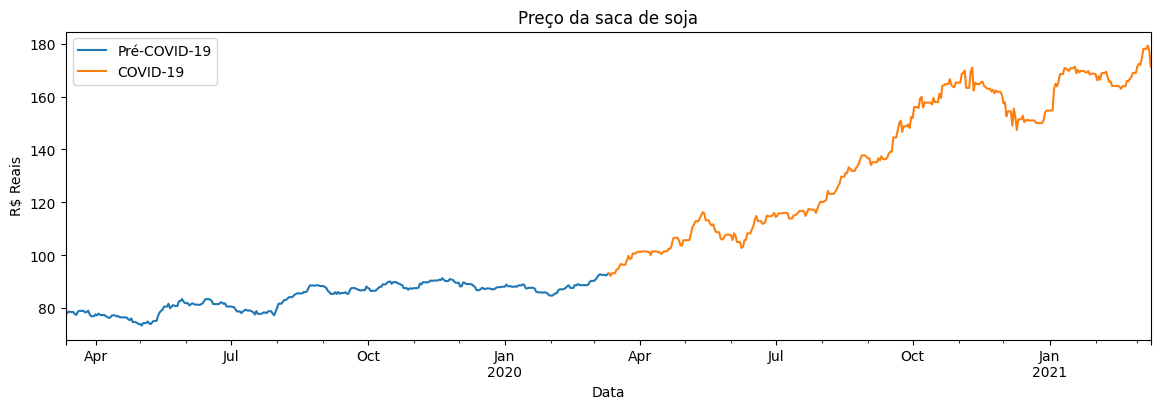

In [ ]:
precovid_plot = precovid
precovid_plot = precovid_plot.set_index('data')
poscovid_plot = poscovid.set_index('data')

plt.rcParams['figure.figsize'] = [14.00, 4]

ax = precovid_plot.plot()
plt.title("Preço da saca de soja")
poscovid_plot.plot(ax= ax)
ax.legend(["Pré-COVID-19","COVID-19"])
plt.ylabel('R$ Reais')
plt.xlabel('Data')
plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/dados_soja_1.png')

## Separação da base de dados em treino e teste

In [ ]:
precovid = precovid.reset_index(drop = True)
precovid

,data,real
0,2019-03-12,77.82
1,2019-03-13,78.13
2,2019-03-14,78.73
3,2019-03-15,78.53
4,2019-03-16,78.53
...,...,...
360,2020-03-06,92.55
361,2020-03-07,92.55
362,2020-03-08,92.55
363,2020-03-09,92.32


In [ ]:
precovid_train = precovid[0:292]
precovid_test_index = precovid[292:365]
precovid_test = precovid[292:365].reset_index(drop = True)

poscovid_train = poscovid[0:292]
poscovid_test = poscovid[292:365].reset_index(drop = True)


In [ ]:
print(poscovid_train.describe())
poscovid_test.describe()

             real
count  292.000000
mean   128.988322
std     23.438444
min     92.180000
25%    108.152500
50%    120.745000
75%    151.400000
max    170.970000


,real
count,73.000000
mean,167.282603
std,5.641261
min,151.050000
25%,164.000000
50%,168.650000
75%,169.690000
max,179.300000


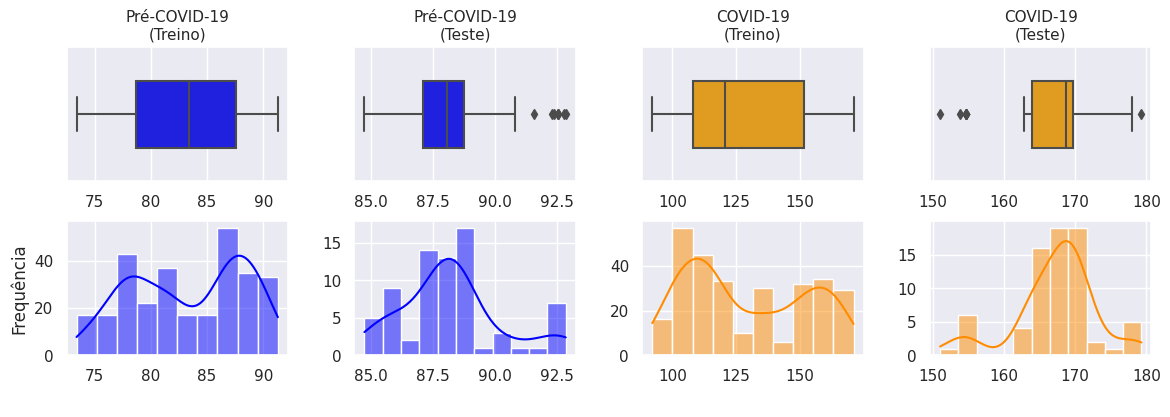

In [ ]:
sns.set(style="darkgrid")

f, (axs) = plt.subplots(2,4)

sns.boxplot(data=precovid_train, x="real", color="blue", ax=axs[0,0], width=0.5)
axs[0,0].set_title('Pré-COVID-19\n(Treino)', size=11)
axs[0,0].set_xlabel(" ")

sns.histplot(data=precovid_train, x="real", kde=True, color="blue", ax=axs[1,0], legend=False)
axs[1,0].set_xlabel(" ")
axs[1,0].set_ylabel("Frequência")

sns.boxplot(data=precovid_test, x="real", color="blue", ax=axs[0,1], width=0.5)
axs[0,1].set_xlabel(" ")
axs[0,1].set_title('Pré-COVID-19\n(Teste)', size=11)

sns.histplot(data=precovid_test, x="real", kde=True, color="blue",alpha=0.5, ax=axs[1,1])
axs[1,1].set_xlabel(" ")
axs[1,1].set_ylabel(" ")

sns.boxplot(data=poscovid_train, x="real", color="orange", ax=axs[0,2], width=0.5)
axs[0,2].set_title('COVID-19\n(Treino)', size=11)
axs[0,2].set_xlabel(" ")
sns.histplot(data=poscovid_train, x="real", kde=True, color="darkorange", ax=axs[1,2])
axs[1,2].set_ylabel(" ")
axs[1,2].set_xlabel(" ")

sns.boxplot(data=poscovid_test, x="real", color="orange", ax=axs[0,3], width=0.5)
axs[0,3].set_title('COVID-19\n(Teste)', size=11)
axs[0,3].set_xlabel(" ")
axs[1,3].set_ylabel(" ")
axs[1,3].set_xlabel(" ")
sns.histplot(data=poscovid_test, x="real", kde=True, color="darkorange",alpha=0.5)

f.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/eda.png')
plt.show()


# Verificação da estacionalidade dos dados

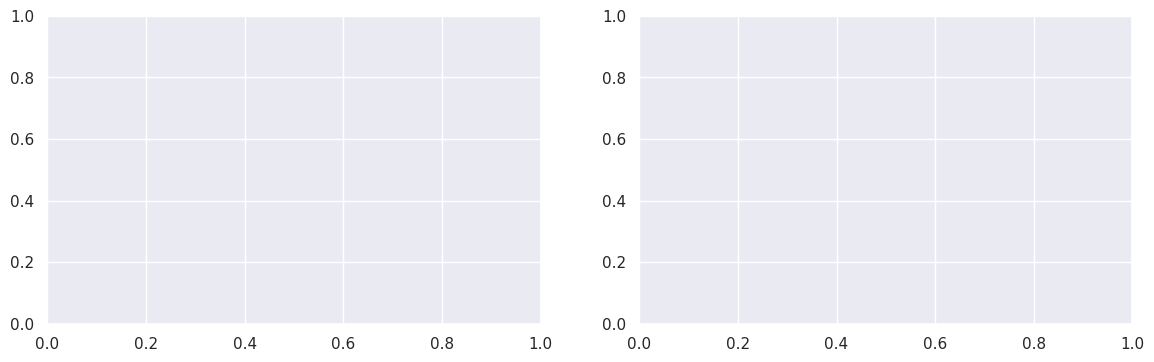

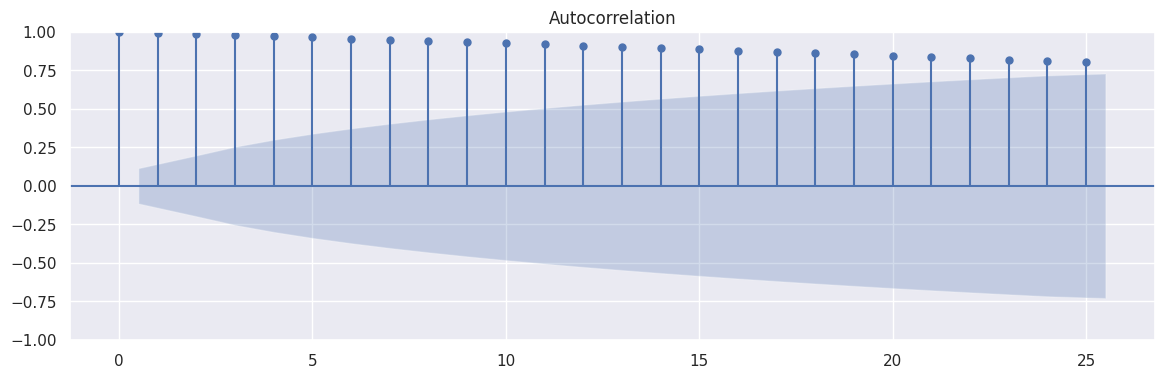

In [ ]:
#Verificando por medio da ACF
sns.set(style="darkgrid")
f, (axs) = plt.subplots(1,2)
#f = plt.figure()
plot_acf(poscovid_train['real'].dropna())
plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/pac_precovid_treino.png')
plt.show()

O grafico da ACF mostra uma queda praticamente nula ao longo dos lags o que da um forte indicio de que a serie não é estacionaria.

Vamos utilizar o teste Dickey-Fuller, o teste verificara se a série é ou não estacionaria a partir da hipotese:

H0 = A série é não estacionaria

H1 = Há fortes indicios estatisticos de que a serie é estacionaria.

In [ ]:
def adfuller_test(teste):
    result=adfuller(teste)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

In [ ]:
adfuller_test(precovid_train['real'])

ADF Test Statistic : -1.0622423917462795
p-value : 0.7298920338650002
#Lags Used : 1
Number of Observations Used : 290
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 


In [ ]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
kpss_test(precovid_train['real'])

Results of KPSS Test:
Test Statistic            2.317035
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# Diferenciando a série para torná-la estacionaria

In [ ]:
precovid_train['primeira_deriv'] = precovid_train['real'].diff(1)
precovid_train['segunda_deriv'] = precovid_train['real'].diff(2)
precovid_train['terceira_deriv'] = precovid_train['real'].diff(3)


<ipython-input-17-8be1d856e0de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precovid_train['primeira_deriv'] = precovid_train['real'].diff(1)
<ipython-input-17-8be1d856e0de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precovid_train['segunda_deriv'] = precovid_train['real'].diff(2)
<ipython-input-17-8be1d856e0de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

###Primeira derivada

In [ ]:
adfuller_test(precovid_train['primeira_deriv'].dropna())
#kpss test testar

ADF Test Statistic : -15.717195822891778
p-value : 1.3373883598010067e-28
#Lags Used : 0
Number of Observations Used : 290
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [ ]:
kpss_test(precovid_train['primeira_deriv'].dropna())

Results of KPSS Test:
Test Statistic           0.07178
p-value                  0.10000
Lags Used                4.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


False


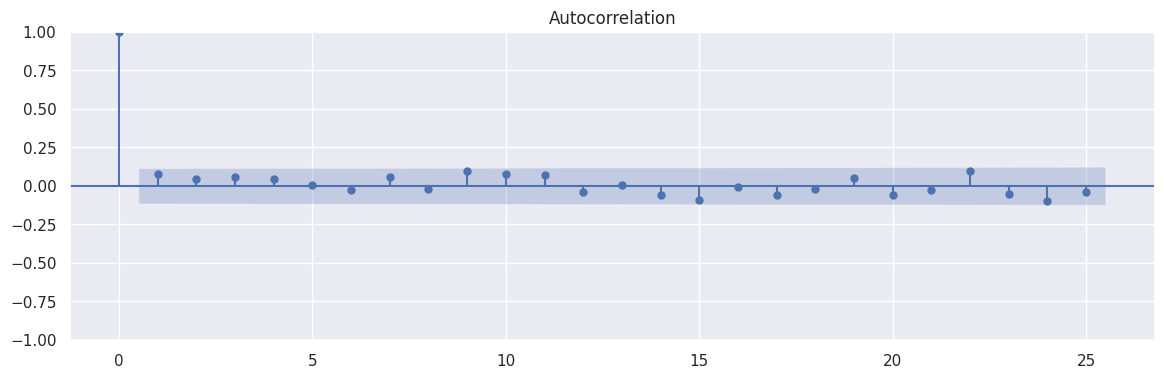

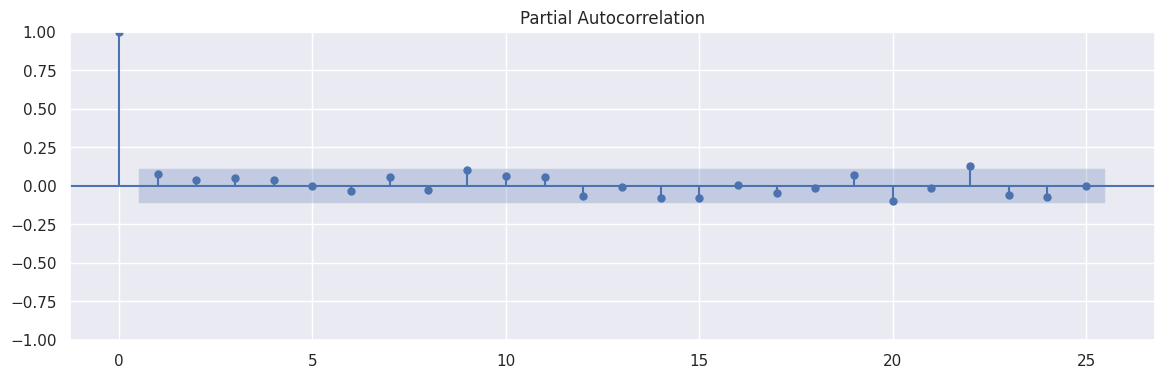

In [ ]:
acf_diff = plot_acf(precovid_train['primeira_deriv'].dropna())
pacf_diff = plot_pacf(precovid_train['primeira_deriv'].dropna())
print(acf_diff == pacf_diff)

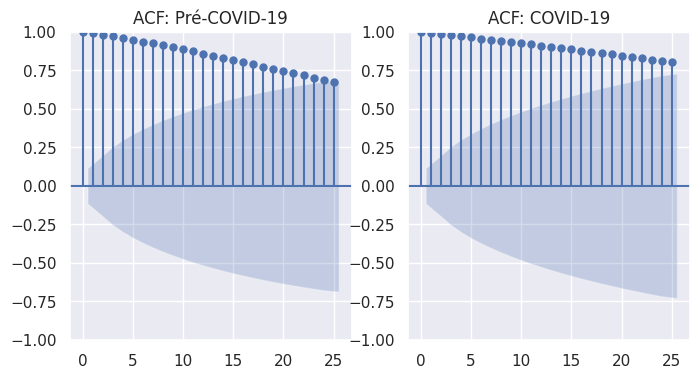

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))

plot_acf(precovid_train['real'], ax=ax1)
ax1.set_title('ACF: Pré-COVID-19')
plot_acf(poscovid_train['real'], ax=ax2)
ax2.set_title('ACF: COVID-19')
plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/acf_inicial.png')
fig.show()

In [ ]:
modelos = pd.DataFrame(columns=['modelo','aic'])

In [ ]:
p = 0
d = 0
q=0
modelo = 0
contador =0
m = 0
order=0
modelo=0

for ar in range (0,5):
  p = ar
  for i in range(1,3):
    d = i
    for ma in range(0,5):
      q = ma
      vetor=[]
      order=(p,d,q)
      vetor.append(order)
      modelo = ARIMA(precovid_train['real'], order= order)
      m = modelo.fit()
      vetor.append(round(m.aic,3))
      modelos.loc[contador] = vetor
      print('modelo:','(',p,d,q,')', '#:',contador, 'vetor:', vetor)
      contador= contador + 1


In [ ]:
modelos = modelos.sort_values('aic', ascending=True).reset_index(drop=True)

In [ ]:
model = ARIMA(precovid_train['real'], order=modelos.loc[0][0],trend='t')
mfit = model.fit()
model1 = ARIMA(precovid_train['real'], order=modelos.loc[1][0],trend='t')
mfit1 = model1.fit()
model2 = ARIMA(precovid_train['real'], order=modelos.loc[2][0],trend='t')
mfit2 = model2.fit()

print(mfit.summary())

                               SARIMAX Results                                
Dep. Variable:                   real   No. Observations:                  292
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -238.122
Date:                Sat, 15 Apr 2023   AIC                            480.243
Time:                        05:42:42   BIC                            487.590
Sample:                             0   HQIC                           483.186
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0346      0.033      1.060      0.289      -0.029       0.099
sigma2         0.3008      0.020     15.352      0.000       0.262       0.339
Ljung-Box (L1) (Q):                   1.74   Jarque-

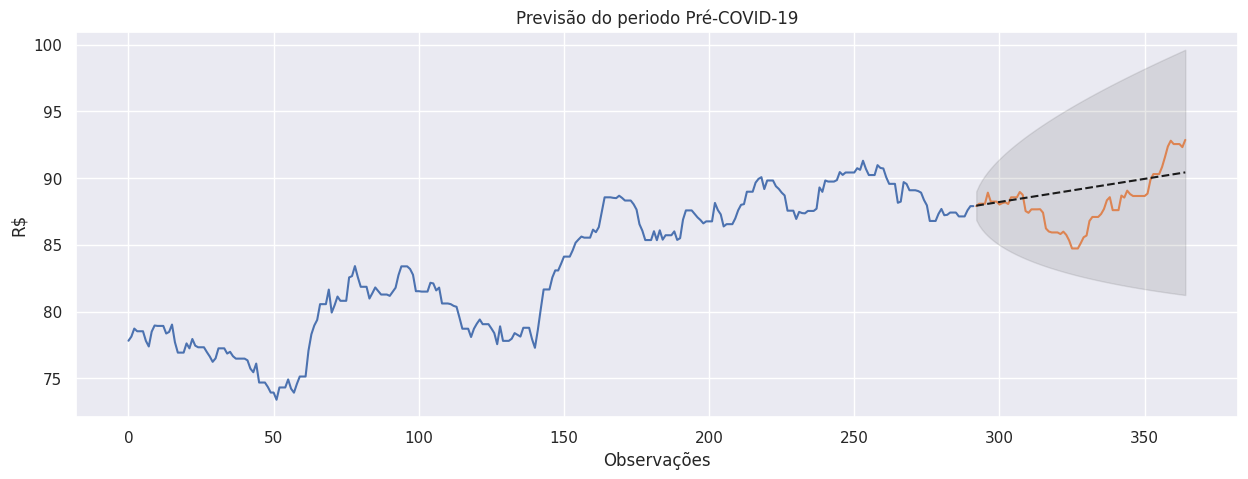

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
precovid_train['real'].plot(ax=ax)
precovid_test_index['real'].plot(ax=ax)
plt.title('Previsão do periodo Pré-COVID-19')
plt.ylabel('R$')
plt.xlabel('Observações')

fcast = mfit.get_forecast(len(precovid_test['real'])).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/graf_previsoes_precovid.png')
#fazer uma tabela que faça para 1, 2, 3 .... todos dados da bd e que mostre o mape

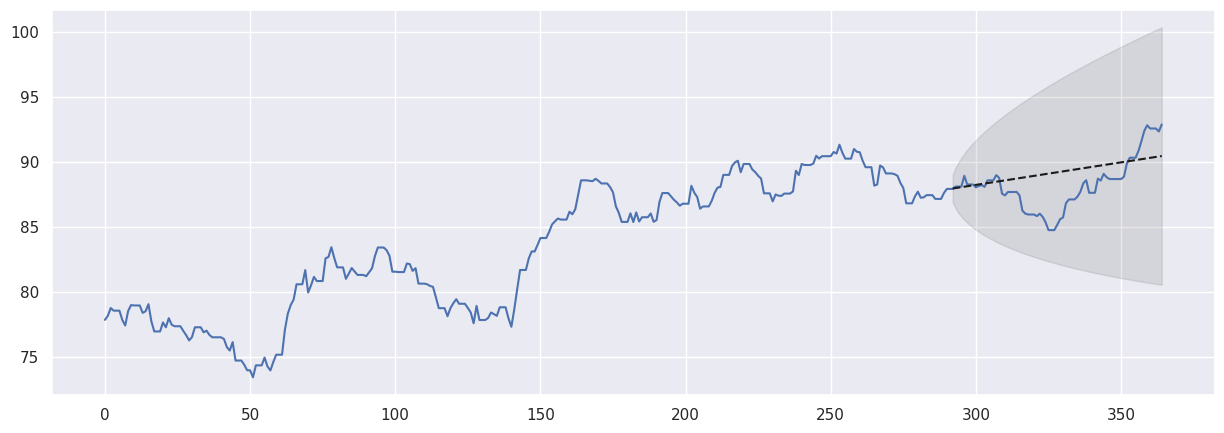

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
precovid['real'].plot(ax=ax)

fcast = mfit1.get_forecast(len(precovid_test['real'])).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
#fazer uma tabela que faça para 1, 2, 3 .... todos dados da bd e que mostre o mape

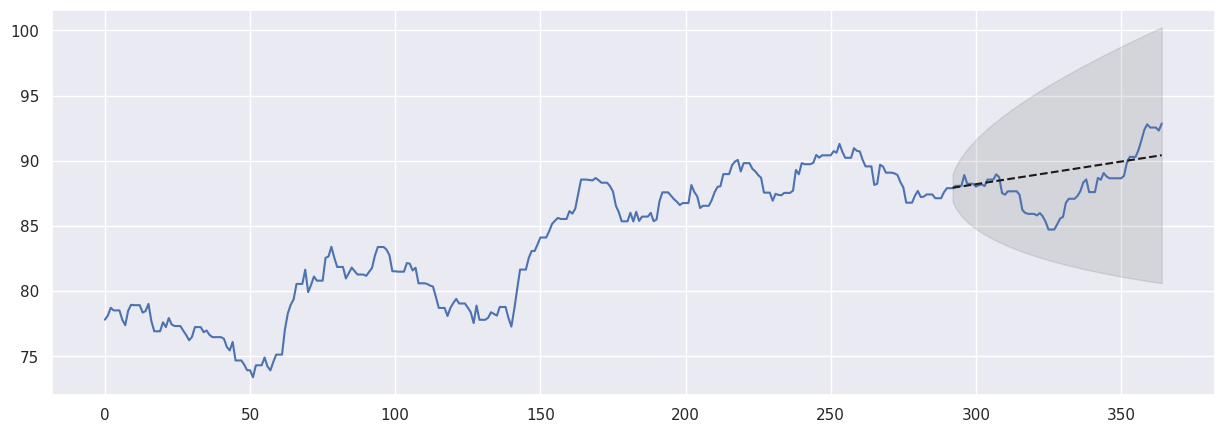

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
precovid['real'].plot(ax=ax)

fcast = mfit2.get_forecast(len(precovid_test['real'])).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
#fazer uma tabela que faça para 1, 2, 3 .... todos dados da bd e que mostre o mape

# Predict de datos

In [ ]:
ypredict = mfit.predict()

In [ ]:
frames = [precovid_train['real'],ypredict]
result = pd.concat(frames, axis=1)
fig = px.line(result)
fig.show()

## Residuo e densidade das predições

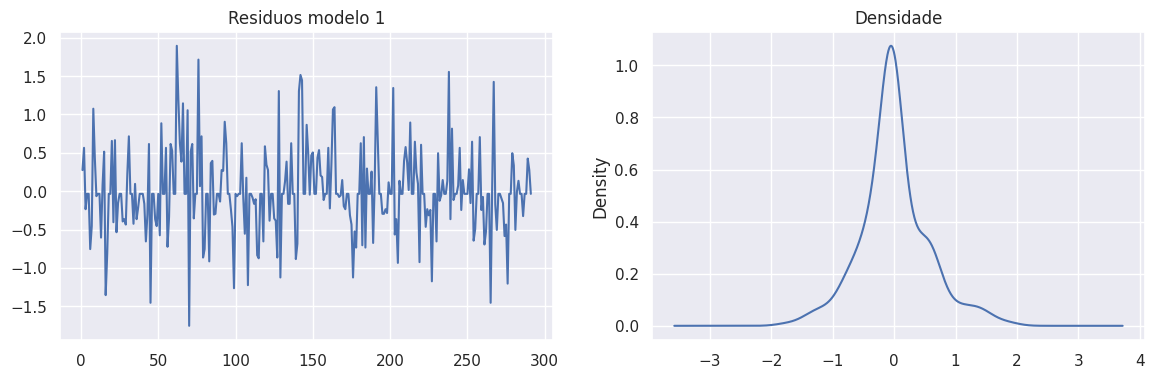

In [ ]:
residuals = mfit.resid[1:]
fig, ax = plt.subplots(nrows=1,ncols=2)
residuals.plot(title='Residuos modelo 1', ax=ax[0])
residuals.plot(title='Densidade',kind='kde', ax=ax[1])

plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



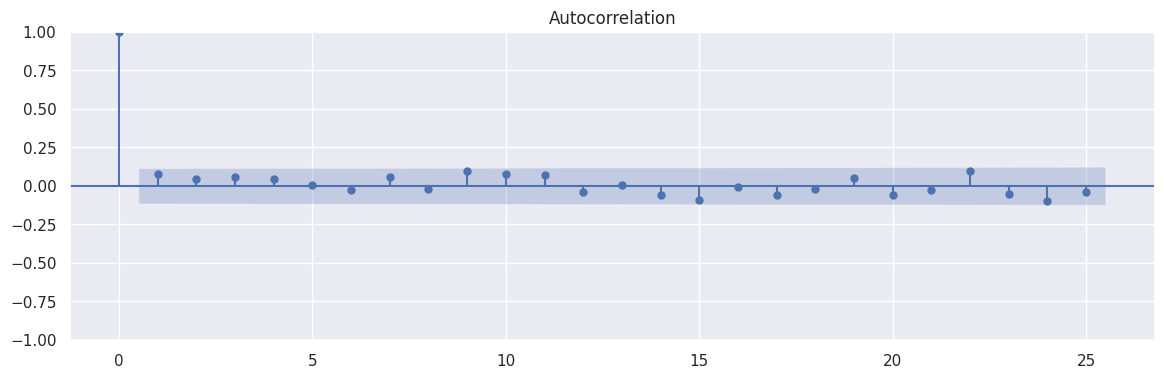

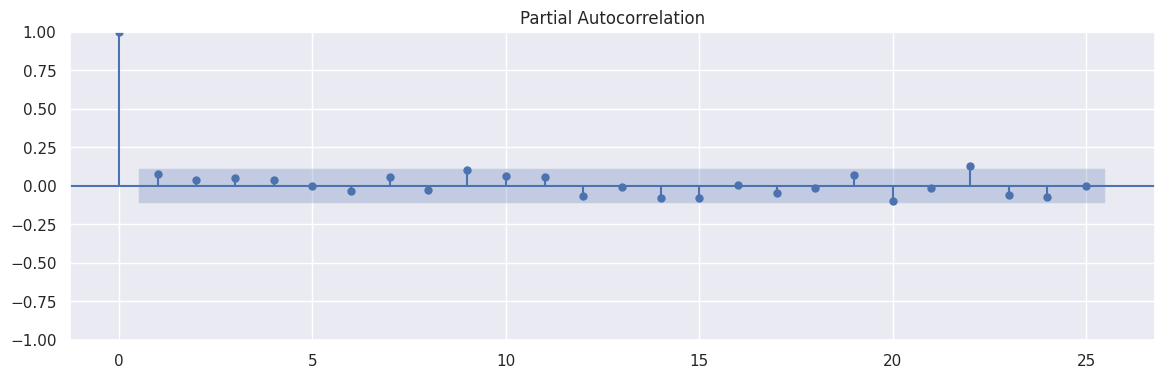

In [ ]:
acf_res1 = plot_acf(residuals)
pacf_res1 = plot_pacf(residuals)

# Forecast

In [ ]:
forecast = mfit.forecast(len(precovid_test))
precovid['forecast'] = [None]*len(precovid_train) + list(forecast)
precovid['get_forecast'] = [None]*len(precovid_train) + list(fcast['mean']) + ([None]*(365 - (len(precovid_train) + len(fcast['mean']))))


In [ ]:
precovid1 = precovid
precovid1.loc[291:366] 

,data,real,forecast,get_forecast
291,2019-12-28,87.90,NaN,NaN
292,2019-12-29,87.90,87.934634,87.930919
293,2019-12-30,88.08,87.969268,87.965591
294,2019-12-31,88.08,88.003903,88.000264
295,2020-01-01,88.08,88.038537,88.034937
...,...,...,...,...
360,2020-03-06,92.55,90.289759,90.288662
361,2020-03-07,92.55,90.324393,90.323334
362,2020-03-08,92.55,90.359027,90.358007
363,2020-03-09,92.32,90.393661,90.392680


<Axes: >

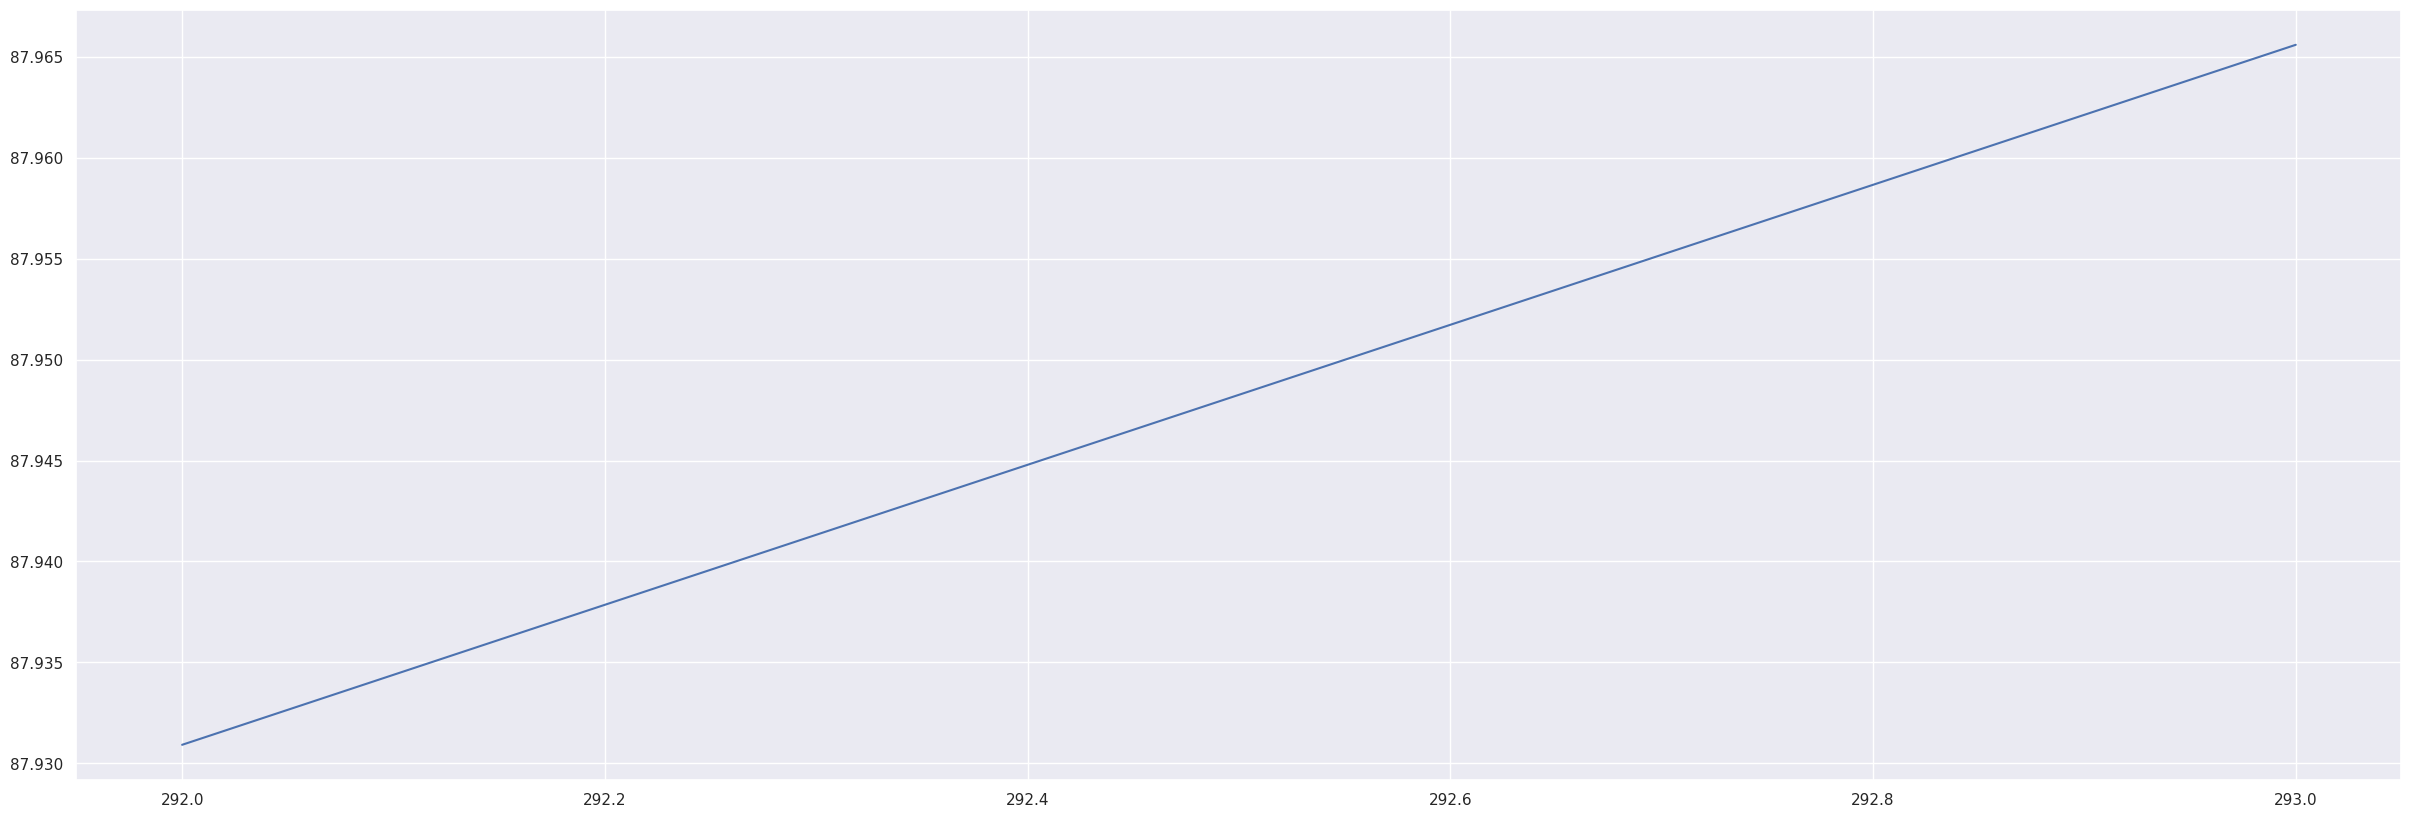

In [ ]:
precovid1.loc[290:293]['get_forecast'].plot(figsize=(30,10))

In [ ]:
precovid1.loc[290:295]

,data,real,forecast,get_forecast
290,2019-12-27,87.90,NaN,NaN
291,2019-12-28,87.90,NaN,NaN
292,2019-12-29,87.90,87.934634,87.930919
293,2019-12-30,88.08,87.969268,87.965591
294,2019-12-31,88.08,88.003903,88.000264
295,2020-01-01,88.08,88.038537,88.034937


# Auto Arima

In [ ]:

import pmdarima as pm

In [ ]:
auto_arima = pm.auto_arima(precovid_train['real'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -238.122
Date:                Sat, 15 Apr 2023   AIC                            480.243
Time:                        05:42:50   BIC                            487.590
Sample:                             0   HQIC                           483.186
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0346      0.033      1.060      0.289      -0.029       0.099
sigma2         0.3008      0.020     15.352      0.000       0.262       0.339
Ljung-Box (L1) (Q):                   1.74   Jarque-

In [ ]:
forecast_auto = auto_arima.predict(n_periods=len(precovid_test))
precovid['auto'] = [None]*len(precovid_train) + list(forecast_auto)
precovid1 = precovid


<Axes: >

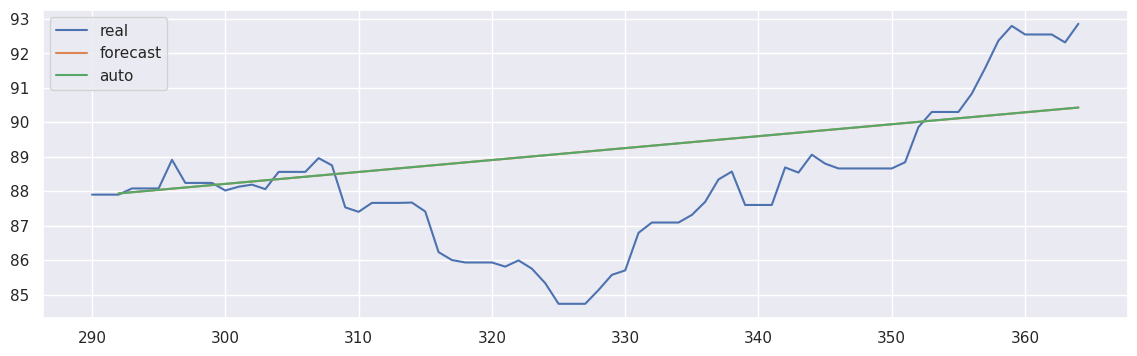

In [ ]:
precovid.iloc[290:366][['real','forecast','auto']].plot()

#Metricas de Performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## Predict

In [ ]:
mae1 = mean_absolute_error(precovid_train['real'],ypredict)
mape1 = mean_absolute_percentage_error(precovid_train['real'],ypredict)
rmse1 = np.sqrt(mean_squared_error(precovid_train['real'],ypredict))
print(f' mae1: {round(mae1,4)}, mape1: {round(mape1,4)}, rmse1: {round(rmse1,4)}')


 mae1: 0.6434, mape1: 0.008, rmse1: 4.5849


In [ ]:
mae1 = mean_absolute_error(precovid.loc[292:294]['real'],precovid1.loc[292:294]['get_forecast'])
mape1 = mean_absolute_percentage_error(precovid.loc[292:294]['real'],precovid1.loc[292:294]['get_forecast'])
rmse1 = np.sqrt(mean_squared_error(precovid.loc[292:294]['real'],precovid1.loc[292:294]['get_forecast']))
print(f' mae1: {round(mae1,4)}, mape1: {round(mape1,4)}, rmse1: {round(rmse1,4)}')


 mae1: 0.075, mape1: 0.0009, rmse1: 0.0825


## Forecast

In [ ]:
mae1 = mean_absolute_error(precovid_test['real'],fcast['mean'])
mape1 = mean_absolute_percentage_error(precovid_test['real'],fcast['mean'])*100
mse1 = mean_squared_error(precovid_test['real'],fcast['mean'])
print(f' mae1: {round(mae1,4)}, mape1: {round(mape1,4)}, rmse1: {round(mse1,4)}')

mae = mean_absolute_error(precovid_test['real'],forecast_auto)
mape = mean_absolute_percentage_error(precovid_test['real'],forecast_auto)
rmse = np.sqrt(mean_squared_error(precovid_test['real'],forecast_auto))
print(f' mae_auto: {round(mae,4)}, mape_auto: {round(mape,4)}, rmse_auto: {round(rmse,4)}')

 mae1: 1.5504, mape1: 1.7731, rmse1: 3.9181
 mae_auto: 1.5513, mape_auto: 0.0177, rmse_auto: 1.9808


In [ ]:
fcast1 = fcast
fcast1 = fcast1.reset_index(drop=True)

In [ ]:
erro = pd.read_excel("/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/arima_2.0/tabela de erros.xlsx")

In [ ]:
erro

,Previsões (Dias),MAE,MAPE,MSE,Covid,MAE_1,MAPE_1,MSE_1
0,1,0.065891,0.074962,0.065891,do lado,1.050806,0.695668,1.104193
1,2,0.194705,0.221132,0.233459,do lado,2.407196,1.570571,7.634384
2,3,0.251901,0.286043,0.284709,do lado,3.032243,1.969766,11.202391
3,4,0.274606,0.311807,0.300264,do lado,3.257847,2.113178,12.272181
4,5,0.435444,0.492117,0.552166,do lado,3.333287,2.160490,12.460455
5,10,0.290108,0.328165,0.408548,do lado,6.010349,3.755665,53.459423
6,20,0.409283,0.464316,0.539224,do lado,11.199405,6.713179,161.709123
7,30,0.946241,1.090542,1.373245,do lado,12.408146,7.386064,181.525307
8,40,1.594518,1.854865,2.157203,do lado,12.123502,7.213993,168.406822
9,50,1.621180,1.878817,2.084420,do lado,11.173850,6.654726,147.043558


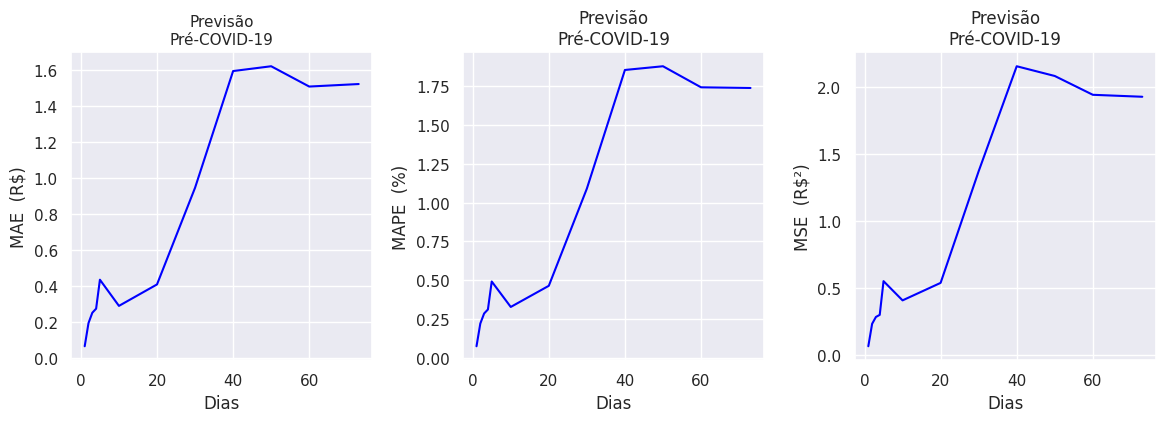

In [ ]:
sns.set(style="darkgrid")

f, (axs) = plt.subplots(1,3)

sns.lineplot(erro, x="Previsões (Dias)",y='MAE', color="blue", ax=axs[0])
axs[0].set_title('Previsão\nPré-COVID-19', size=11)
axs[0].set_xlabel("Dias")
axs[0].set_ylabel("MAE  (R$)")

sns.lineplot(data=erro, x="Previsões (Dias)", y="MAPE", color="blue", ax=axs[1], legend=False)
axs[1].set_xlabel("Dias")
axs[1].set_title("Previsão\nPré-COVID-19")
axs[1].set_ylabel("MAPE  (%)")

sns.lineplot(data=erro, x="Previsões (Dias)", y="MSE", color="blue", ax=axs[2], legend=False)
axs[2].set_xlabel("Dias")
axs[2].set_title("Previsão\nPré-COVID-19")
axs[2].set_ylabel("MSE  (R$²)")

f.subplots_adjust(wspace=0.3)
plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/erros_previsoes_precovid.png')
plt.show()

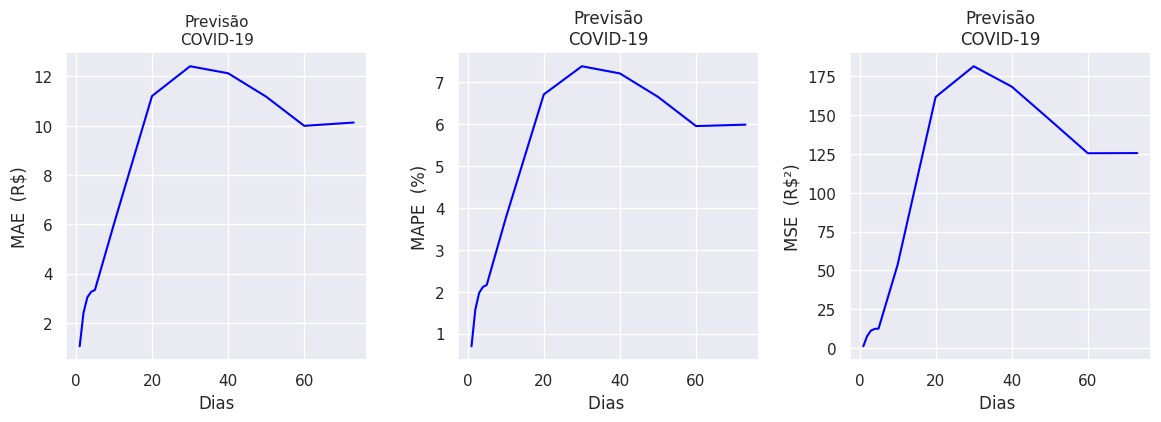

In [ ]:
sns.set(style="darkgrid")

f, (axs) = plt.subplots(1,3)

sns.lineplot(erro, x="Previsões (Dias)",y='MAE_1', color="blue", ax=axs[0])
axs[0].set_title('Previsão\nCOVID-19', size=11)
axs[0].set_xlabel("Dias")
axs[0].set_ylabel("MAE  (R$)")

sns.lineplot(data=erro, x="Previsões (Dias)", y="MAPE_1", color="blue", ax=axs[1], legend=False)
axs[1].set_xlabel("Dias ")
axs[1].set_title("Previsão\nCOVID-19")
axs[1].set_ylabel("MAPE  (%)")

sns.lineplot(data=erro, x="Previsões (Dias)", y="MSE_1", color="blue", ax=axs[2], legend=False)
axs[2].set_xlabel("Dias ")
axs[2].set_title("Previsão\nCOVID-19")
axs[2].set_ylabel("MSE  (R$²)")

f.subplots_adjust(wspace=0.3)
plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/erros_previsoes_covid.png')
plt.show()